# Background Removal
We aim to remove the background from a video and be able to select only the moving parts using SVD.

We use as benchmark the real video 003 dataset from BMC 2012 [Background Models Challenge Dataset](http://backgroundmodelschallenge.eu/)

In [1]:
!wget http://backgroundmodelschallenge.eu/data/real/Video_003.zip
!unzip Video_003.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


Import needed libraries:

In [3]:
import moviepy.editor as mpe
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt

Load the video and check its duration

In [13]:
video = mpe.VideoFileClip("Video_003/Video_003.avi")
video.duration

113.57

Let us visualize the video, and actually check its contents

In [14]:
def create_data_matrix_from_video(clip, dims):
    number_of_frames = int(clip.fps * clip.duration)
    flatten_gray_frames = []
    for i in range(number_of_frames):
        # get_frame takes as input the time of the frame
        frame = clip.get_frame(i / clip.fps)
        # to gray scale
        gray_frame = np.mean(frame[..., :3], axis=-1).astype(int)
        # resize to reduce computational cost
        small_gray_frame = skimage.transform.resize(gray_frame, dims)
        # each frame becomes a column vector of A
        flatten_gray_frames.append(small_gray_frame.flatten())
    return np.vstack(flatten_gray_frames).T

We set some parameters and create the matrix



In [35]:
scale = 0.75   # Adjust scale to change resolution of image
width, height = video.size
dims = (int(height * scale), int(width * scale))
A = create_data_matrix_from_video(video, dims)
print("frame size:", dims)
print("video matrix size:", A.shape)

frame size: (180, 240)
video matrix size: (43200, 794)


Let's visualize the 140-th frame of the video (rescaled and decolored)

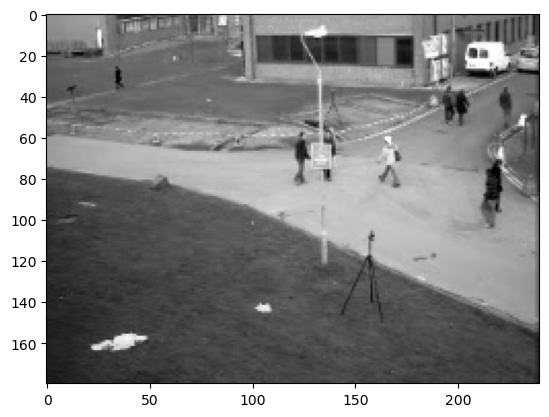

In [36]:
plt.imshow(np.reshape(A[:,140], dims), cmap='gray')

What does the matrix A look like instead?

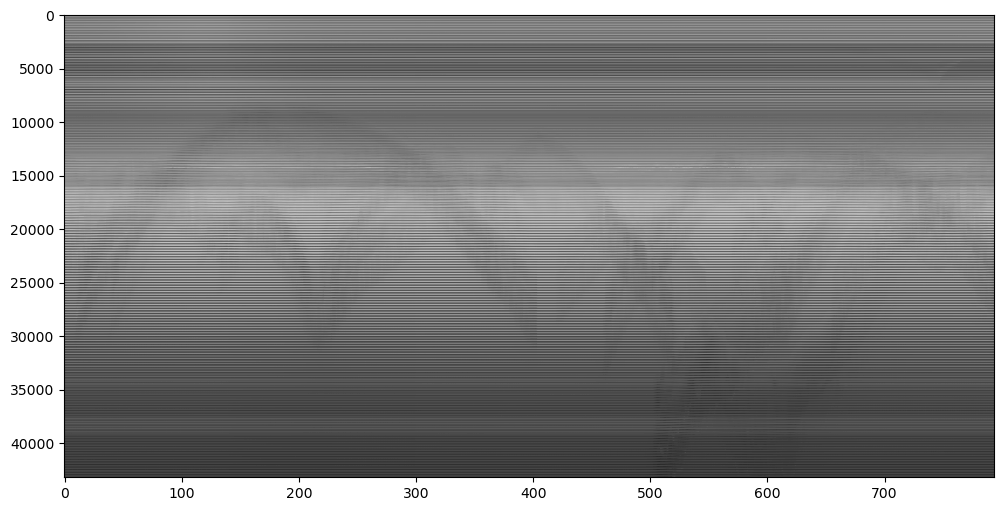

In [37]:
plt.figure(figsize=(12, 6))
plt.imshow(A, cmap='gray', aspect='auto')


**Questions**: What are those wavy black lines? What are the horizontal lines?


## Apply the SVD
We apply the SVD to our matrix $A$

In [38]:
U,S,Vt = np.linalg.svd(A, full_matrices=False)
U.shape, S.shape, Vt.shape

((43200, 794), (794,), (794, 794))


Check that they are a decomposition of A

In [39]:
A_reconstructed = U @ np.diag(S) @ Vt
np.allclose(A, A_reconstructed)

True

Since the background is more or less constant during the video (the horizontal lines of A), we suppose that the background can be reconstructed using few (try 1 or 2) singular values

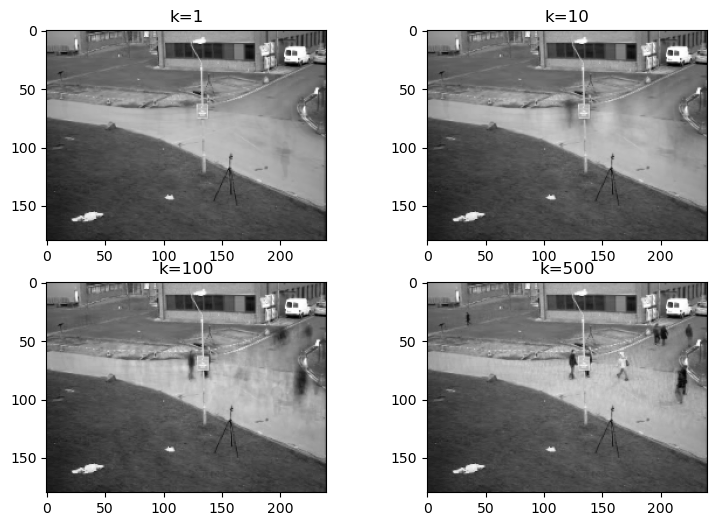

In [40]:
k_vals = [1,10,100,500]

fig, ax = plt.subplots(2,2,figsize=(9,6))
ax = ax.ravel()
for i,k in enumerate(k_vals):
    background = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]
    ax[i].imshow(np.reshape(background[:,140],dims),cmap='gray')
    ax[i].set_title(f'k={k}')

The more singular values we use, the more the video will be reconstructed. To keep only the background, we just take a few

In [41]:
background = U[:, :10] @ np.diag(S[:10]) @ Vt[:10, :]

The SVD has done all the heavy liflting!
Now we "just" have to visualize the results in a human comprehensible way.


Let's visualize the original video, the background and the foreground at some fixed instances in time.

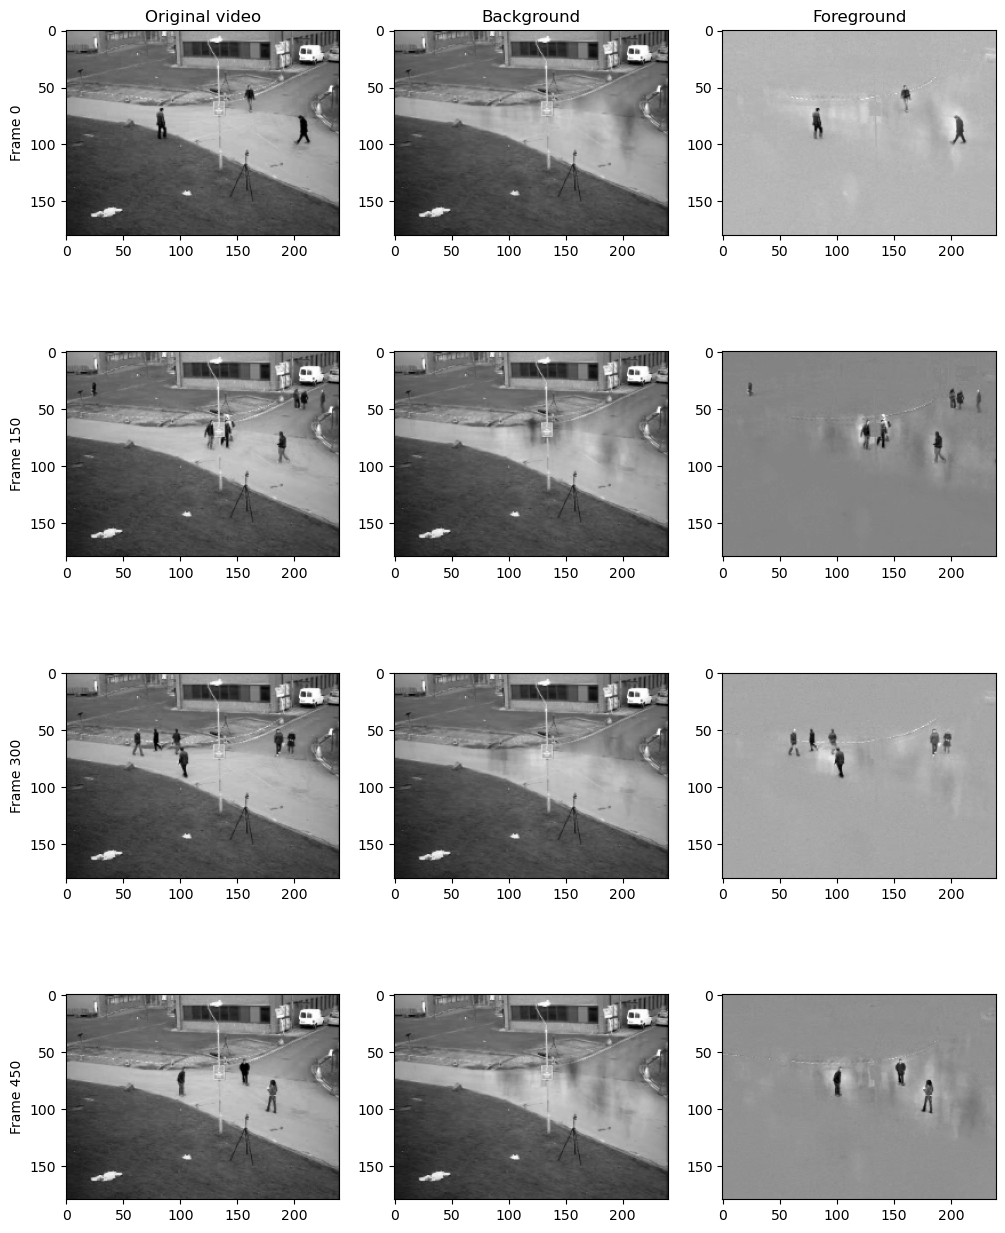

In [42]:
def plot_frames(A, background, time_ids):
  fig, axs = plt.subplots(len(time_ids), 3, figsize=(12, 4 * len(time_ids)))
  for i, t_id in enumerate(time_ids):
    axs[i, 0].imshow(np.reshape(A[:, t_id], dims), cmap='gray')
    axs[i, 1].imshow(np.reshape(background[:, t_id], dims), cmap='gray')
    axs[i, 2].imshow(np.reshape(A[:, t_id] - background[:, t_id], dims), cmap='gray')

    axs[i, 0].set_ylabel(f"Frame {t_id}")

    if i == 0:
      axs[0, 0].set_title("Original video")
      axs[0, 1].set_title("Background")
      axs[0, 2].set_title("Foreground")

time_ids = [0, 150, 300, 450]
plot_frames(A, background, time_ids)


What are the downsides?

SVD was really slow (remember that we also compressed our frames to reduce the computational cost). Moreover, we threw away a lot of our calculation, we used just one singular value.

